In [1]:
import pystac_client
import planetary_computer
import stackstac
import json
import geopandas as gpd
import matplotlib.pyplot as plt

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

GEOJSON_PATH = "./data/farm.geojson"

time_range = "2009-01/2020-01"

geojson = gpd.read_file(GEOJSON_PATH)
bbox = geojson.bounds.values[0]

search = catalog.search(collections=["landsat-c2-l2"], bbox=bbox, datetime=time_range)
items = search.get_all_items()


In [2]:
stack = stackstac.stack(items, bounds_latlon=bbox)
stack

<xarray.DataArray 'stackstac-a0ef308245c89d92819ad9698dd54deb' (time: 1397,
                                                                band: 22, y: 7,
                                                                x: 9)>
dask.array<fetch_raster_window, shape=(1397, 22, 7, 9), dtype=float64, chunksize=(1, 1, 7, 9), chunktype=numpy.ndarray>
Coordinates: (12/31)
  * time                         (time) datetime64[ns] 2009-01-08T16:43:31.04...
    id                           (time) <U31 'LT05_L2SP_027028_20090108_02_T1...
  * band                         (band) <U13 'qa' 'red' ... 'qa_aerosol'
  * x                            (x) float64 5.144e+05 5.144e+05 ... 5.146e+05
  * y                            (y) float64 5.032e+06 5.032e+06 ... 5.032e+06
    landsat:scene_id             (time) <U21 'LT50270282009008EDC00' ... 'LE7...
    ...                           ...
    title                        (band) object 'Surface Temperature Quality A...
    classification:bitfields     (band) object None ... [{'name': 'fill', 'le...
    common_name                  (band) object None None None ... 'coastal' None
    center_wavelength            (band) object None None None ... 10.9 0.44 None
    full_width_half_max          (band) object None None None ... 0.59 0.02 None
    epsg                         int64 32615
Attributes:
    spec:        RasterSpec(epsg=32615, bounds=(514410.0, 5031750.0, 514680.0...
    crs:         epsg:32615
    transform:   | 30.00, 0.00, 514410.00|\n| 0.00,-30.00, 5031960.00|\n| 0.0...
    resolution:  30.0

In [3]:
# Make a bitmask---when we bitwise-and it with the data, it leaves just the 4 bits we care about
mask_bitfields = [1, 2, 3, 4]  # dilated cloud, cirrus, cloud, cloud shadow
bitmask = 0
for field in mask_bitfields:
    bitmask |= 1 << field

bin(bitmask)

qa = stack.sel(band="qa_pixel").astype("uint16")
bad = qa & bitmask  # just look at those 4 bits

good = stack.where(bad == 0)  # mask pixels where any one of those bits are set

In [4]:
nir, red = good.sel(band="nir08"), good.sel(band="red")
ndvi = (nir - red) / (nir + red)
ndvi = ndvi.persist() # Dask compute

In [5]:
ndvi

<xarray.DataArray 'stackstac-a0ef308245c89d92819ad9698dd54deb' (time: 1397,
                                                                y: 7, x: 9)>
dask.array<truediv, shape=(1397, 7, 9), dtype=float64, chunksize=(1, 7, 9), chunktype=numpy.ndarray>
Coordinates: (12/22)
  * time                         (time) datetime64[ns] 2009-01-08T16:43:31.04...
    id                           (time) <U31 'LT05_L2SP_027028_20090108_02_T1...
  * x                            (x) float64 5.144e+05 5.144e+05 ... 5.146e+05
  * y                            (y) float64 5.032e+06 5.032e+06 ... 5.032e+06
    landsat:scene_id             (time) <U21 'LT50270282009008EDC00' ... 'LE7...
    eo:cloud_cover               (time) float64 0.0 30.0 92.0 ... 100.0 100.0
    ...                           ...
    proj:epsg                    int64 32615
    landsat:correction           <U4 'L2SP'
    platform                     (time) <U9 'landsat-5' ... 'landsat-7'
    landsat:wrs_path             (time) <U3 '027' '026' '026' ... '026' '027'
    landsat:wrs_row              (time) <U3 '028' '028' '029' ... '029' '028'
    epsg                         int64 32615

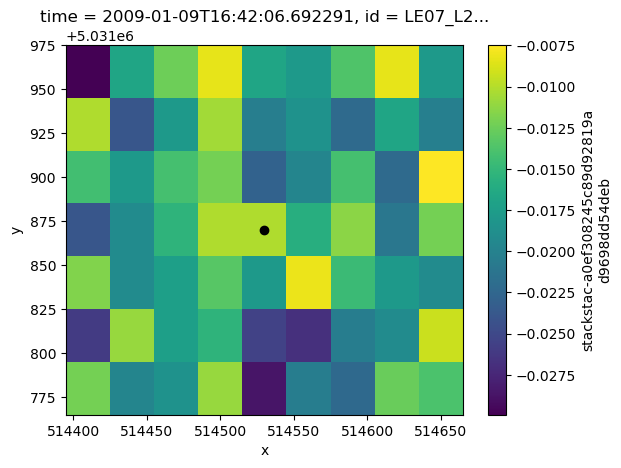

In [6]:
ndvi.isel(time=1).plot.imshow()
plt.plot(514530., 5031870, 'ko')

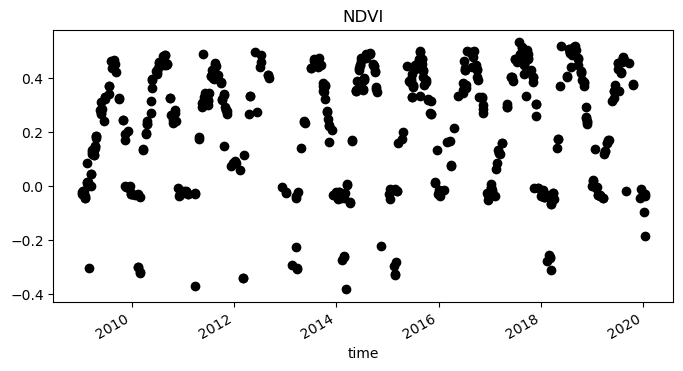

In [7]:
xcen = -423850
ycen = 5100220
# select nearest point and plot timeserie
s = ndvi.sel(x=xcen, y=ycen, method="nearest").to_series()
s.plot(title='NDVI', figsize=(8,4), style='ko')
plt.savefig('ts.png', dpi=1000)